# IoT Planning 

**Input**: data from telco's customers with demographic, services and account information.

**Output**: flask application with form to be filled with customer's information. The application should return with the prediction result if the customer will or will not churn in that month.

**Tasks**:
- data description
- end-to-end solution
- metrics definition
- data cleaning
- check the unbalency
- feature engineering
- eda
- data preparation
- feature selection
- ml models
- hyperparameters fine tuning
- deploy

# 0.0 Imports

In [2]:
from IPython.core.display      import HTML
from pycaret.classification    import *
from scikitplot                import metrics         as mt
from sklearn                   import model_selection as ms
from sklearn                   import preprocessing   as pp
from sklearn                   import metrics         as m
from keras                     import models          as ml
from keras                     import layers          as l
from scipy                     import stats           as ss

import matplotlib.pyplot as plt
import pandas            as pd
import seaborn           as sns
import numpy             as np

import inflection

## 0.1 Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container{width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set

jupyter_settings()

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

Populating the interactive namespace from numpy and matplotlib


## 0.2 Load Data

In [4]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# 1.0 Data Description

In [5]:
df1 = df_train.copy()

## 1.1 Data Dimension

In [6]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 5634
Number of columns: 21


## 1.2 Rename Columns

In [7]:
cols_old = ['id', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
            'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
            'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
            'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
            'MonthlyCharges', 'TotalCharges', 'Churn']
snakecase = lambda x: inflection.underscore(x)
new_cols = list(map(snakecase, cols_old))
df1.columns = new_cols

In [8]:
cols_old = ['id', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges']
snakecase = lambda x: inflection.underscore(x)
new_cols = list(map(snakecase, cols_old))
df_test.columns = new_cols

## 1.3 Data Types

In [9]:
df1.dtypes

id                     int64
gender                object
senior_citizen         int64
partner               object
dependents            object
tenure               float64
phone_service         object
multiple_lines        object
internet_service      object
online_security       object
online_backup         object
device_protection     object
tech_support          object
streaming_tv          object
streaming_movies      object
contract              object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges         object
churn                  int64
dtype: object

## 1.4 Check N/A

In [10]:
df1.isna().sum()

id                     0
gender                 0
senior_citizen         0
partner                0
dependents           218
tenure               461
phone_service          0
multiple_lines         0
internet_service       0
online_security        0
online_backup          0
device_protection      0
tech_support           0
streaming_tv           0
streaming_movies       0
contract               0
paperless_billing      0
payment_method        99
monthly_charges        0
total_charges          0
churn                  0
dtype: int64

## 1.5 Check Balanced Data

In [11]:
df1['churn'].value_counts(normalize=True)

0    0.734647
1    0.265353
Name: churn, dtype: float64

## 1.5 Replace N/A

In [12]:
#dependents > replace with No
df1.loc[df1['dependents'].isna(), 'dependents'] = 'No'
#tenure > replace with mean
df1.loc[df1['tenure'].isna(), 'tenure'] = 32.0
#payment_method > replace with "Not specified"
df1.loc[df1['payment_method'].isna(), 'payment_method'] = 'Not specified'

## 1.6 Change Data Types

In [13]:
df1['total_charges'] = pd.to_numeric(df1['total_charges'], errors='coerce')
df1['tenure'] = df1['tenure'].astype(int)
df1['total_charges'] = df1['total_charges'].astype(float)

In [14]:
df_test['total_charges'] = pd.to_numeric(df_test['total_charges'], errors='coerce')
df_test['tenure'] = df1['tenure'].astype(int)
df_test['total_charges'] = df1['total_charges'].astype(float)

## 1.7 Statistics Description

In [15]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

## 1.7.1  Numerical Attributes 

In [16]:
#central tendency (mean, median)
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion (std, min, max, range, skew, kurtosis)
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#final dataset
num_desc = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
num_desc.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
num_desc

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.00,7043.00,7042.0,3530.313454,3525.50,2036.014395,0.000004,-1.202118
1,senior_citizen,0.00,1.00,1.0,0.158679,0.00,0.365377,1.868818,1.493010
2,monthly_charges,18.25,118.75,100.5,64.626438,70.25,30.019141,-0.216087,-1.257425
3,total_charges,18.80,8684.80,8666.0,2273.513811,NaN,2258.183227,0.970766,-0.205691
4,churn,0.00,1.00,1.0,0.265353,0.00,0.441521,1.063185,-0.869947


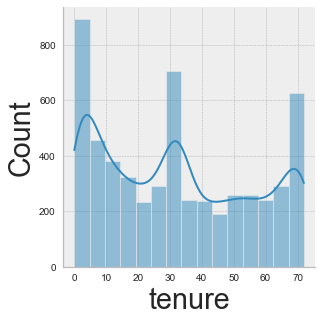

In [17]:
a = sns.displot(data=df1, x='tenure', kde=True);
plt.show();

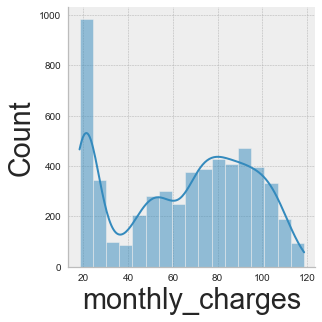

In [18]:
a = sns.displot(data=df1, x='monthly_charges', kde=True);
plt.show();

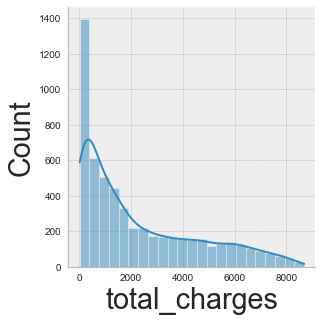

In [19]:
a = sns.displot(data=df1, x='total_charges', kde=True);
plt.show();

## 1.7.2 Categorical Attributes 

In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender                2
partner               2
dependents            2
tenure               73
phone_service         2
multiple_lines        3
internet_service      3
online_security       3
online_backup         3
device_protection     3
tech_support          3
streaming_tv          3
streaming_movies      3
contract              3
paperless_billing     2
payment_method        5
dtype: int64

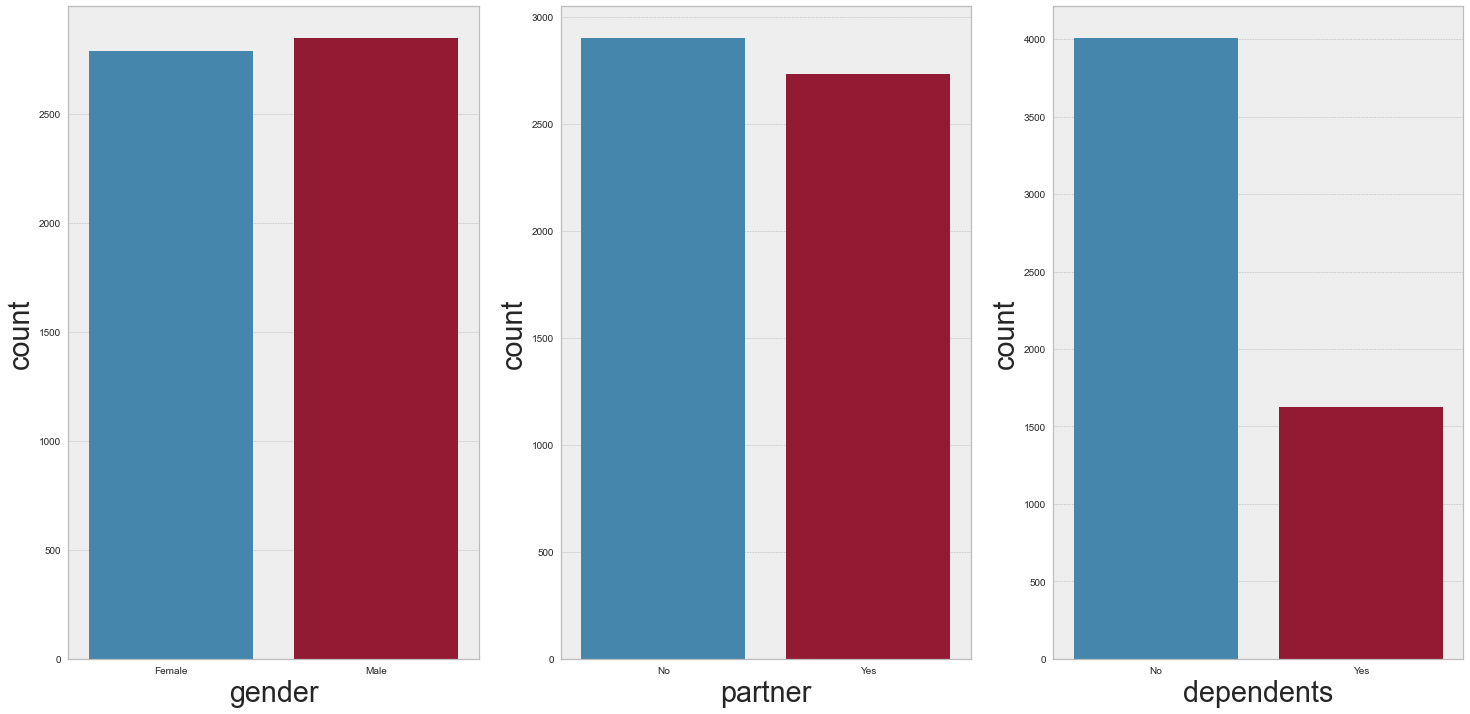

In [21]:
plt.subplot(1, 3, 1)
sns.countplot(df1['gender'])

plt.subplot(1, 3, 2)
sns.countplot(df1['partner'])

plt.subplot(1, 3, 3)
sns.countplot(df1['dependents'])
plt.show()

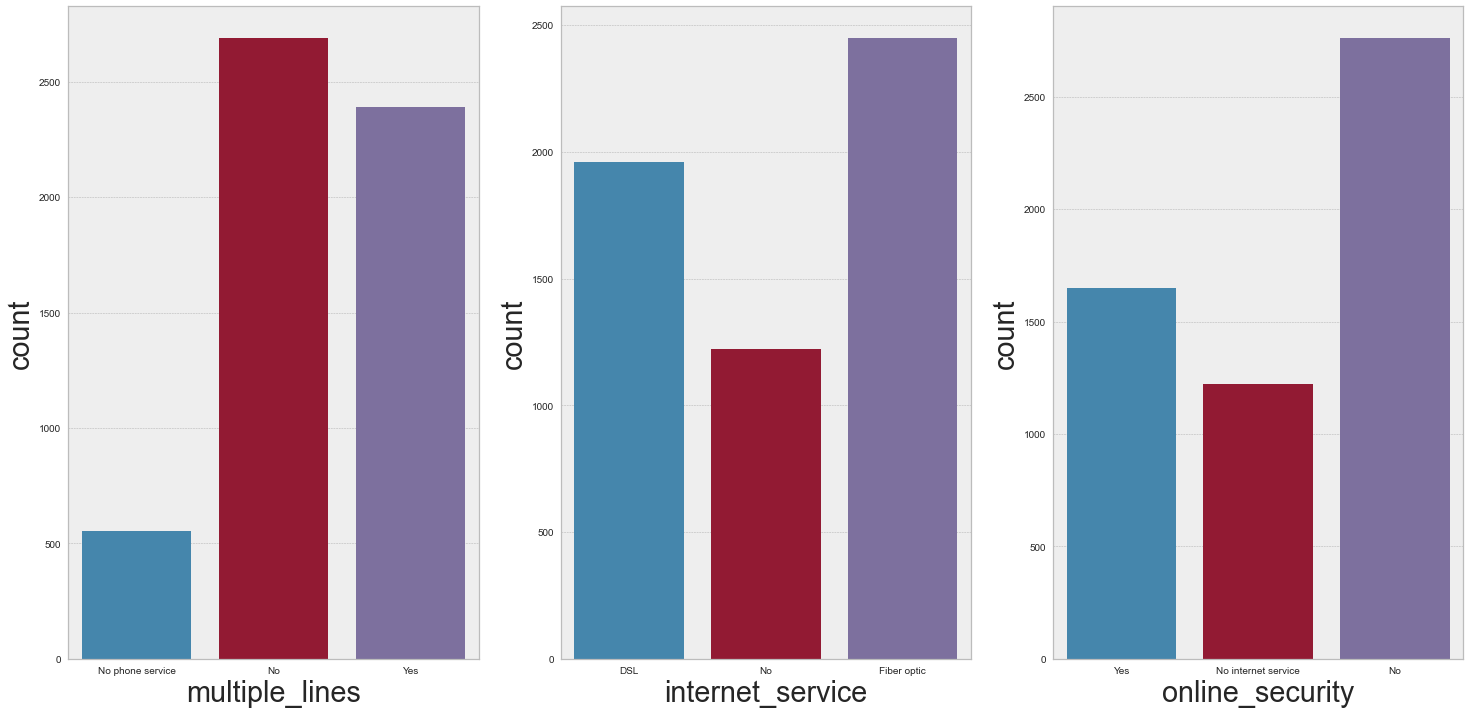

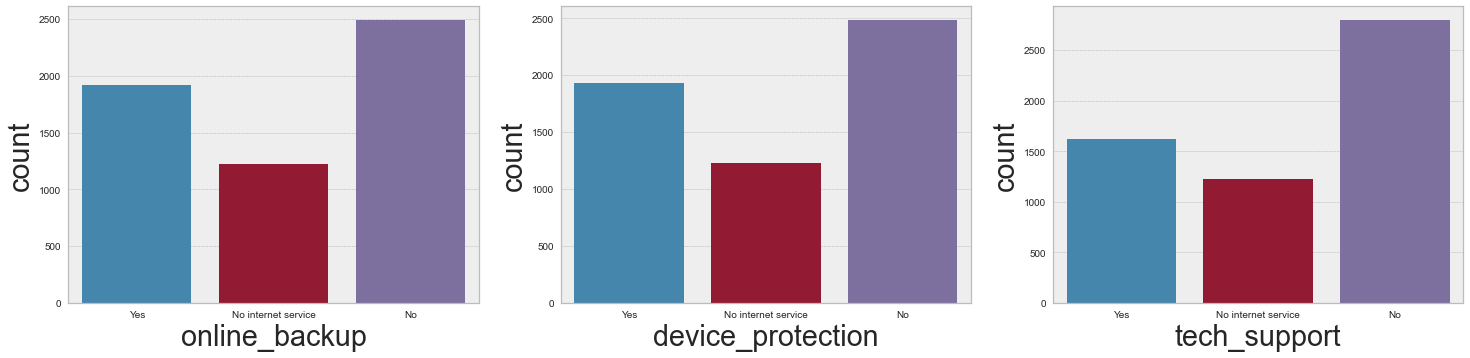

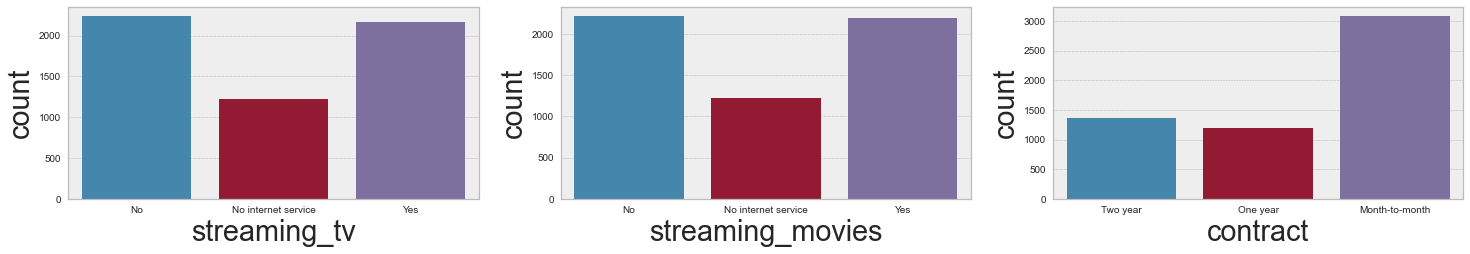

In [22]:
plt.subplot(1, 3, 1)
sns.countplot(df1['multiple_lines'])

plt.subplot(1, 3, 2)
sns.countplot(df1['internet_service'])

plt.subplot(1, 3, 3)
sns.countplot(df1['online_security'])
plt.show()

plt.subplot(2, 3, 1)
sns.countplot(df1['online_backup'])

plt.subplot(2, 3, 2)
sns.countplot(df1['device_protection'])

plt.subplot(2, 3, 3)
sns.countplot(df1['tech_support'])
plt.show()

plt.subplot(3, 3, 1)
sns.countplot(df1['streaming_tv'])

plt.subplot(3, 3, 2)
sns.countplot(df1['streaming_movies'])

plt.subplot(3, 3, 3)
sns.countplot(df1['contract'])
plt.show()

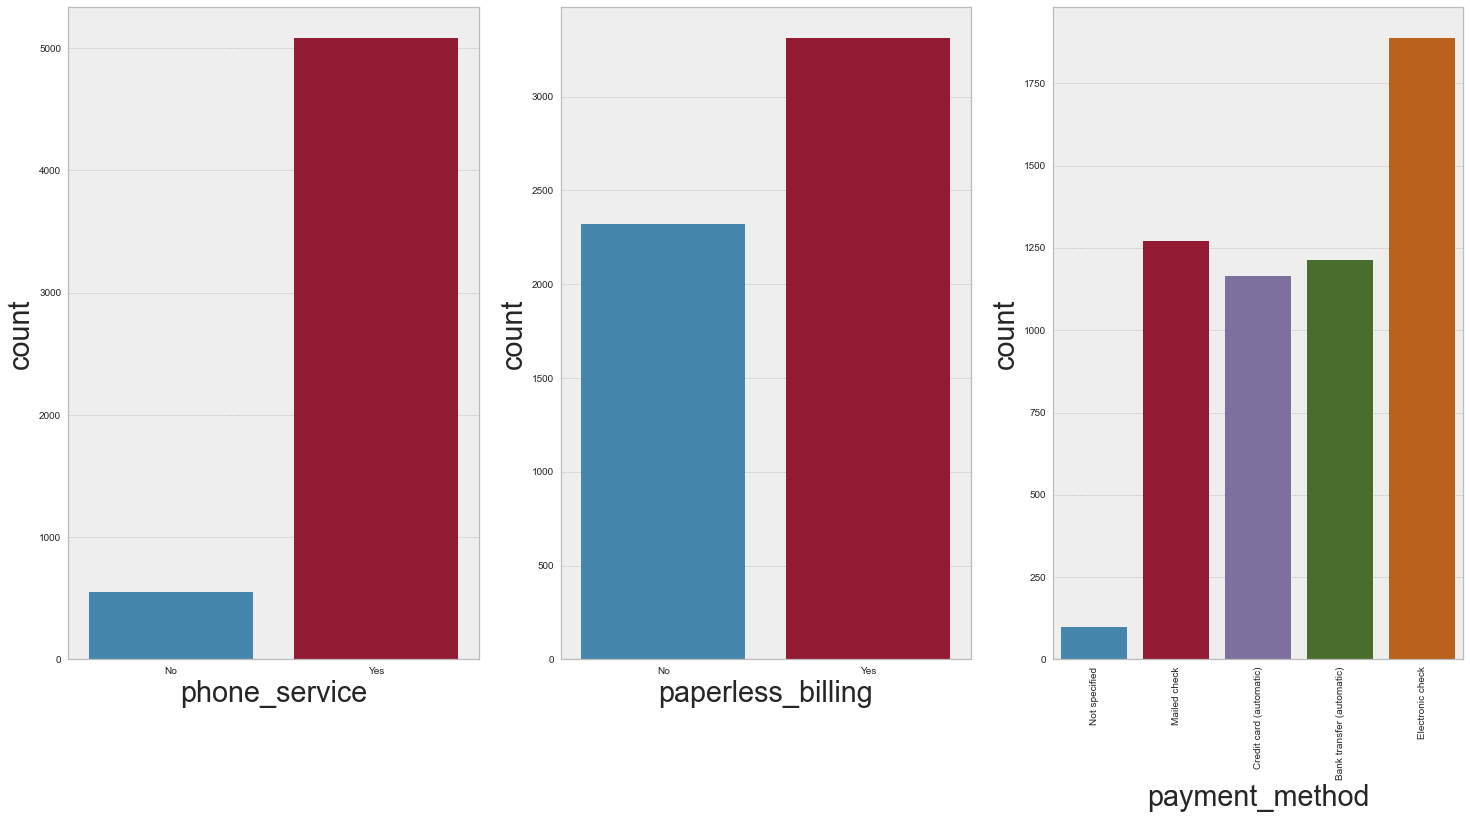

In [23]:
plt.subplot(1, 3, 1)
sns.countplot(df1['phone_service'])

plt.subplot(1, 3, 2)
sns.countplot(df1['paperless_billing'])

plt.subplot(1, 3, 3)
sns.countplot(df1['payment_method'])
plt.xticks(rotation=90)
plt.show()

In [24]:
cat_attibutes_list = cat_attributes.columns.tolist()
corr_dict = {}
for i in range(len(cat_attibutes_list)):
    corr_list=[]
    for j in range(len(cat_attibutes_list)):
        ref = cat_attibutes_list[i]
        feat = cat_attibutes_list[j]
        #correlation
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        #append to list
        corr_list.append(corr)
    #append a correlation list for each ref attribute
    corr_dict[ref] = corr_list

<AxesSubplot:>

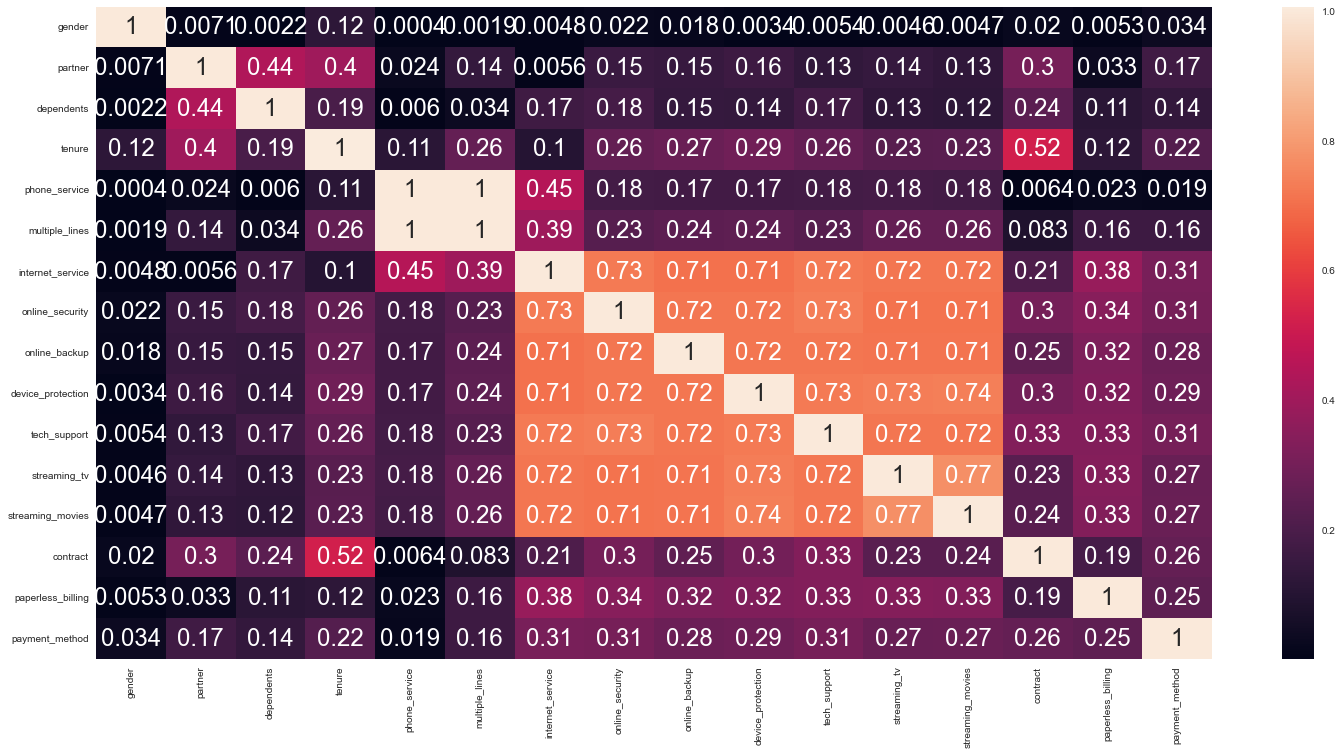

In [25]:
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

# Model w/ Pycaret

In [26]:
setup(data=df1, target='churn')

,Description,Value
0,session_id,8257
1,Target,churn
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(5634, 21)"
5,Missing Values,True
6,Numeric Features,4
7,Categorical Features,16
8,Ordinal Features,False
9,High Cardinality Features,False


(None,
 '6742',
         id  gender  senior_citizen partner dependents  tenure phone_service    multiple_lines internet_service      online_security  ...    device_protection         tech_support         streaming_tv     streaming_movies        contract paperless_billing             payment_method monthly_charges  total_charges  churn
 0     4030  Female               0      No         No      56            No  No phone service              DSL                  Yes  ...                  Yes                  Yes                   No                   No        Two year                No              Not specified           45.05        2560.10      0
 1     6731    Male               0     Yes        Yes      32           Yes                No               No  No internet service  ...  No internet service  No internet service  No internet service  No internet service        One year                No               Mailed check           19.65         332.65      0
 2     6479  Female  

In [27]:
best_model = compare_models(n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8062,0.0000,0.5354,0.6687,0.5934,0.4686,0.4743,0.0140
gbc,Gradient Boosting Classifier,0.8035,0.8495,0.5411,0.6581,0.5930,0.4652,0.4697,0.3850
ada,Ada Boost Classifier,0.8024,0.8472,0.5592,0.6473,0.5987,0.4689,0.4719,0.1640
lr,Logistic Regression,0.8014,0.8422,0.5373,0.6550,0.5889,0.4599,0.4647,0.8570
lda,Linear Discriminant Analysis,0.8009,0.8413,0.5622,0.6443,0.5988,0.4676,0.4705,0.0260
rf,Random Forest Classifier,0.7971,0.8346,0.5076,0.6535,0.5696,0.4400,0.4470,0.3210
lightgbm,Light Gradient Boosting Machine,0.7943,0.8391,0.5383,0.6331,0.5796,0.4452,0.4491,0.2480
et,Extra Trees Classifier,0.7771,0.8094,0.4923,0.5987,0.5391,0.3942,0.3982,0.3200
nb,Naive Bayes,0.7459,0.8316,0.7792,0.5149,0.6197,0.4409,0.4624,0.0160
dt,Decision Tree Classifier,0.7439,0.6779,0.5373,0.5176,0.5266,0.3513,0.3519,0.0250


In [28]:
len(df1.loc[df1['churn']==0])/len(df1)

0.7346467873624423

In [29]:
t = tune_model(best_model[0])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8000,0.0000,0.5238,0.6548,0.5820,0.4527,0.4576
1,0.8253,0.0000,0.5619,0.7195,0.6310,0.5188,0.5257
2,0.7646,0.0000,0.4095,0.5811,0.4804,0.3341,0.3426
3,0.7944,0.0000,0.5673,0.6211,0.5930,0.4558,0.4567
4,0.7843,0.0000,0.4904,0.6145,0.5455,0.4064,0.4108
5,0.8249,0.0000,0.5481,0.7215,0.6230,0.5117,0.5199
6,0.8198,0.0000,0.6058,0.6774,0.6396,0.5200,0.5214
7,0.8122,0.0000,0.5810,0.6703,0.6224,0.4983,0.5006
8,0.8096,0.0000,0.4762,0.7143,0.5714,0.4553,0.4708
9,0.8249,0.0000,0.5810,0.7093,0.6387,0.5247,0.5292


In [30]:
final_model = finalize_model(t)

In [31]:
predict = predict_model(final_model, df_test)
predict

,id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,Label
0,5027,Male,0,Yes,Yes,56,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Credit card (automatic),20.00,2560.10,0
1,1733,Male,1,Yes,Yes,32,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,One year,No,NaN,99.00,332.65,1
2,5384,Male,0,No,No,60,Yes,Yes,Fiber optic,No,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,84.75,6640.70,0
3,6554,Female,0,Yes,Yes,37,No,No phone service,DSL,No,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),61.45,3545.35,0
4,364,Female,0,No,No,29,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,20.55,1974.80,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,4897,Male,0,No,NaN,42,Yes,No,DSL,No,...,Yes,No,No,No,Month-to-month,Yes,Mailed check,49.70,2386.85,0
1405,6940,Male,0,No,No,32,Yes,No,Fiber optic,Yes,...,No,Yes,No,Yes,One year,Yes,Electronic check,89.20,1448.60,0
1406,804,Female,0,Yes,No,32,Yes,No,DSL,No,...,No,Yes,Yes,No,Two year,Yes,Credit card (automatic),64.20,3340.55,0
1407,1143,Male,1,Yes,Yes,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Credit card (automatic),75.20,325.45,1


In [32]:
len(predict.loc[predict['Label']==0])

1088

In [33]:
len(predict.loc[predict['Label']==1])

321